In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
from matplotlib.lines import Line2D
import qinfer as qi
from scipy import linalg
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
import seaborn as sns

sys.path.append("/home/bf16951/QMD")
import qmla
%matplotlib inline

In [2]:
from latex_figure import LatexFigure

# Load QMLA instance

In [3]:
results_time = 'Oct_26/21_35'

results_folder = os.path.abspath("/home/bf16951/QMD/Launch/Results/")
results_dir = os.path.join(
    results_folder, 
    results_time
)

run_id = '001'

try:
    results_file = os.path.join(results_dir, 'results_{}.p'.format(run_id))
    res = pickle.load(open(results_file, 'rb'))
except:
    results_file = os.path.join(results_dir, 'results_m1_q{}.p'.format(run_id))
    res = pickle.load(open(results_file, 'rb'))
    
    
true_params = pickle.load(open(os.path.join(results_dir, 'run_info.p'), 'rb')) 
qmla_class_file = os.path.join(results_dir, 'qmla_class_{}.p'.format(run_id))
plot_probes = pickle.load(open(os.path.join(results_dir, 'plot_probes.p'), 'rb'))
true_measurements = pickle.load(open(os.path.join(results_dir, 'system_measurements.p'), 'rb'))
q = pickle.load(open(qmla_class_file, 'rb'))
try:
    q2 = pickle.load(open(os.path.join(results_dir, 'qmd_class_002.p'), 'rb'))
except:
    pass
gr = q.growth_class
try:
    combined_datasets = os.path.join(results_dir, 'combined_datasets')
    evaluation_data = pickle.load(open(os.path.join(results_dir, 'evaluation_data.p' ), 'rb'))
    storage = pickle.load(open(os.path.join(results_dir, 'storage_{}.p'.format(run_id)), 'rb'))
    system_probes = pickle.load(open(
        os.path.join(results_dir, 'training_probes', 'system_probes.p'),
        'rb'
    ))
    ga = gr.genetic_algorithm
except:
#     raise
    pass


try:
    # these are only available if analysis has been performed
    champ_info = pickle.load(open(os.path.join(results_dir, 'champion_models',  'champions_info.p' ), 'rb'))
    bf = pd.read_csv(os.path.join(combined_datasets,  'bayes_factors.csv' ))
    fitness_df = pd.read_csv(os.path.join(combined_datasets,  'fitness_df.csv' ))
    combined_results = pd.read_csv(os.path.join(results_dir, 'combined_results.csv'))
    correlations = pd.read_csv(
        os.path.join(combined_datasets, "fitness_correlations.csv")
    )
    fitness_by_f_score = pd.read_csv(
        os.path.join(combined_datasets, 'fitness_by_f_score.csv')
    )
except:
    pass

# Plot QHL instances

In [29]:
def parameter_learning_analyses(
    datasets, 
    difference = r"$N_P$",
    plots_to_do = ['volume'], 
    legend_order = None,
    results_folder = os.path.abspath("/home/bf16951/QMD/Launch/Results/"), 
    palette='Blues',
    save_to_file=None,
    lf_params={},
    just_dfs=False
):

    all_instances_progress = pd.DataFrame()
    all_parameter_estimtes = pd.DataFrame()

    for d in datasets: 
        dataset = datasets[d]
        q_path = os.path.join(results_folder, dataset, 'qmla_class_001.p')
        qmla_instance = pickle.load(open(q_path, 'rb'))
        model_instance = qmla_instance.get_model_storage_instance_by_id(1)
        progress = model_instance.progress_tracker
        progress['test'] = d
        progress['dataset'] = dataset
        all_instances_progress = all_instances_progress.append(
            progress, ignore_index=True
        )
        # Need to cast some columns as floats (not sure why not done automatically)
        for col in ['experiment_time', 'residual_median', 'residual_std_dev']:
            all_instances_progress[col] = all_instances_progress[col].astype(float)
            
        all_instances_progress['test'] = all_instances_progress['test'].astype(str)

        param_estimates = model_instance.parameter_estimates
        param_estimates['test'] = d
        param_estimates['dataset'] = dataset
        param_estimates.reset_index(None, inplace=True)
        all_parameter_estimtes = all_parameter_estimtes.append(
            param_estimates, 
            ignore_index=True
        )
#         all_parameter_estimtes['test'] = all_parameter_estimtes['test'].astype(str)
    if just_dfs:
        return all_instances_progress, all_parameter_estimtes
        
    if legend_order is None: 
        order = list(sorted(datasets.keys()))
    else: 
        order = legend_order
        
    # Draw plots
    lf = LatexFigure(
        plot_style='default',
        use_gridspec=True, 
        **lf_params
    )
    draw_xticks = True
    legend_type = 'full'
    ylabel_pad = 7.5

    if 'parameters' in plots_to_do:
        ax = lf.new_axis()

        sns.lineplot(
            y = 'pauliSet_1_z_d1', 
            x = 'experiment_id', 
            hue = 'test', 
            data = all_parameter_estimtes,
#             hue_order = order, 
            legend=legend_type, 
            palette=palette,
            ax = ax
        )
        ax.set_ylabel(r"$\bar{\omega}$", rotation=0, labelpad=ylabel_pad)
        ax.set_xlabel("Experiment")
        ax.axhline(7.75, ls='--', c='grey') # MANUALLY SET TRUE PARAM...

    if 'volume' in plots_to_do:   
        ax = lf.new_axis()
        legend_type='full'

        sns.lineplot(
            x = 'experiment_id', 
            y = 'volume', 
            data = all_instances_progress,
            hue='test',
            legend=legend_type, 
            hue_order = order, 
            palette=palette,
            ax = ax
        )
        ax.semilogy()
        ax.set_ylabel(r"$V$", rotation=0, labelpad=ylabel_pad)
        ax.set_xlabel('Experiment')

        
    if 'quadratic_loss' in plots_to_do:   
        ax = lf.new_axis()
        legend_type='full'

        sns.lineplot(
            x = 'experiment_id', 
            y = 'quadratic_loss', 
            data = all_instances_progress,
            hue='test',
            legend=legend_type, 
            hue_order = order, 
            palette=palette,
            ax = ax
        )

        ax.semilogy()
        ax.set_ylabel(r"$L_Q$", rotation=0, labelpad=ylabel_pad)
        ax.set_xlabel('Experiment')   
        
    if 'experiment_times' in plots_to_do: 
        ax = lf.new_axis()

        sns.lineplot(
            x = 'experiment_id', 
            y = 'experiment_time',
            data = all_instances_progress,
            hue='test',
            legend=legend_type, 
            hue_order = order, 
            palette=palette,
            ax = ax
        )
        ax.semilogy()
        ax.set_ylabel(r"$t$", rotation=0,labelpad=ylabel_pad)
        ax.set_xlabel('Experiment')
        
    if 'residuals' in plots_to_do:
        ax = lf.new_axis()

        sns.lineplot(
            x = 'experiment_id', 
            y = 'residual_median', 
            data = all_instances_progress,
            hue='test',
            legend=legend_type, 
            hue_order = order, 
            palette=palette,
            ax = ax
        )
        ax.semilogy()
        ax.set_ylabel(r'$r$', rotation=90)
        ax.set_xlabel('Experiment')   
        
    return all_instances_progress, all_parameter_estimtes, lf

In [30]:

datasets = {
    r"100" : 'Oct_27/20_48',
    r"1000" : 'Oct_27/19_40',
    r"$2000 \ (r_t=0.5)$" : 'Oct_27/20_22',
    r"$2000 \ (r_t=0.9)$" : 'Oct_27/21_00',

}

legend_order = [
    r"100", r"1000",r"$2000 \ (r_t=0.5)$", r"$2000 \ (r_t=0.9)$"
]
legend_order = [
    a for a in legend_order if a not  in 
    list(set(legend_order) - set(datasets))
] # reduce to only those in datasets considered

# manually list colours to use in plots
display_colours = [plt.cm.tab10(i) for i in np.arange(0, 1, 0.1)]
my_colour_set = iter(display_colours)
pallete = {
    d : next(my_colour_set)
    for d in legend_order
} # need to manually set pallete https://github.com/mwaskom/seaborn/issues/1515

plots_to_do = [
    'parameters', 
    'volume', 
    'quadratic_loss', 
    'experiment_times', 
#     'residuals', 
    
#     'dynamics'
]
lf_params = {
    'font_scale' : 1, 
    'auto_gridspec' : None,
    'gridspec_layout' : (3,2),
    'rc_params' : {'lines.markersize' : 5},
    'gridspec_params' : {
        'hspace' : 0.3, 
        'wspace' : 0.3,
        'height_ratios' : [1,1,0.1,]
    },
    'rc_params' : {
        'lines.linewidth' : 0.5,
    },
    'legend_axis' : (2,1)
}

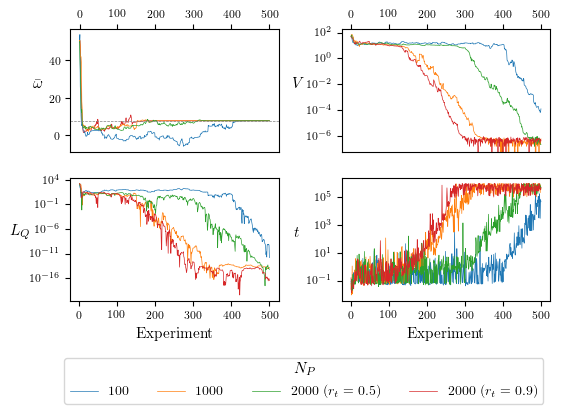

In [31]:
all_instances_progress, all_parameter_estimtes, lf = parameter_learning_analyses(
    datasets = datasets, 
    plots_to_do = plots_to_do,
    legend_order = legend_order, 
    palette=pallete,
    save_to_file='param_learning',
    lf_params = lf_params, 
    just_dfs = False, 
)

for row, col in lf.gridspec_axes:
    if (row, col) == lf.legend_grid_pos:
        continue
    ax = lf.gridspec_axes[(row, col)]
    if row == 0:
        ax.set_xlabel('')
        ax.tick_params(
            top = True,
            bottom = False,
            labeltop = True,
            labelbottom = False
        )
    else:
        ax.set_xlabel('Experiment')
#     ax.set_ylabel(rotation=90)

    leg = ax.get_legend()
    leg.set_visible(False)
    if row == col == 1:
        handles, labels = ax.get_legend_handles_labels()

# legend_ax = lf.new_axis()
legend_ax = lf.legend_ax
legend_ax.legend(
    handles[1:], # excluding title element
    labels[1:], 
    title=r"$N_P$",
    ncol=len(plots_to_do),
    bbox_to_anchor=(1,-1)
)
legend_ax.axis('off')

lf.save('params')